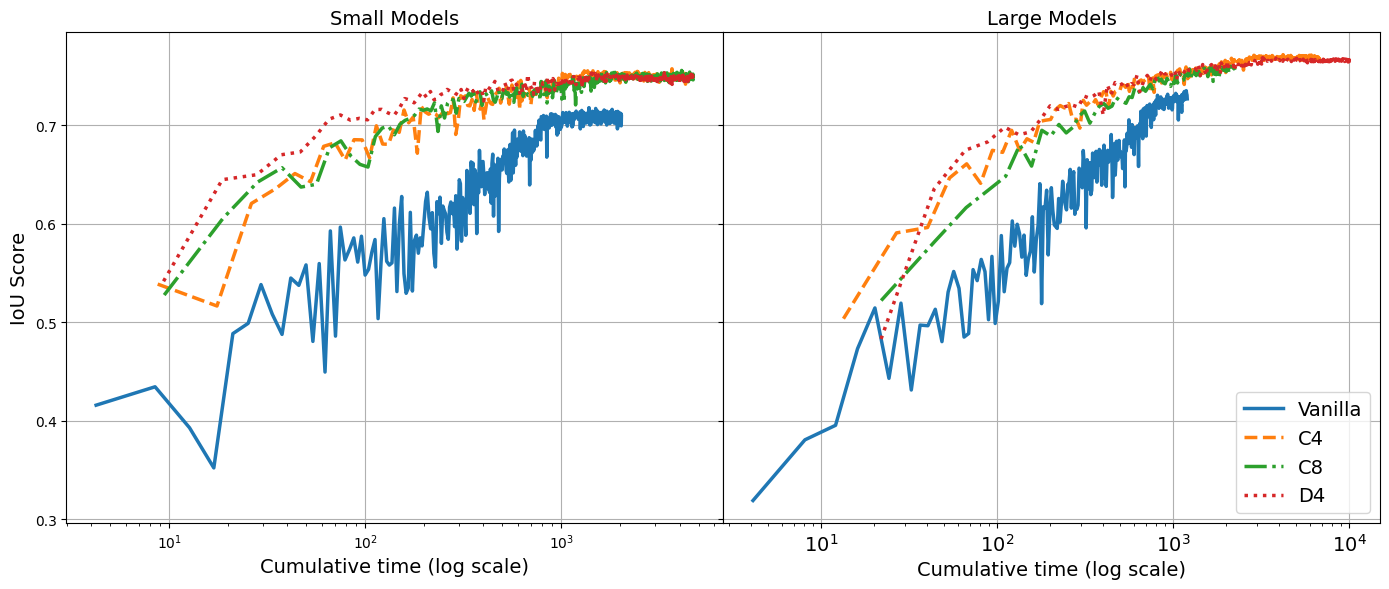

In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd'] 
selected_font_size = 14
output_dir_base_path = f'/home/rob/Documents/3_projects/bench/analysis/graphs/'

def construct_path_from_parent(root_dir, subdir_list):
    # Construct the path using os.path.join
    return os.path.join(root_dir, *subdir_list)

def build_path(dataset_name: str, 
               model_name: str, 
               fold_nb: str, 
               model_size: str, 
               root_base_dir: str = '/home/rob/Documents/3_projects/bench/_results') -> str:
    root_dir = os.path.join(root_base_dir, model_size)
    subdirs = [dataset_name, model_name, fold_nb, "summary.json"]

    summary_loc = construct_path_from_parent(root_dir, subdirs)
    if os.path.exists(summary_loc):
        ...
    else:
        print(f'No file at the path you provided: {summary_loc}.')
    
    return summary_loc

# Function to load and process model data
def load_model_data(model_names, folds, dataset_name, model_size):
    model_dicts = {}
    for model_name in model_names:
        model_dicts[model_name] = {}
        metric_time_dict = {}
        for fold in folds:
            metric_time_dict[fold] = {}
            summary_loc = build_path(dataset_name, model_name, fold, model_size)
            with open(summary_loc) as file:
                data = json.load(file)
                
            # Extract performance and time data
            data = data.get('test', {})
            perf_list = data[perf_metric]
            time_list = data['time']
            
            metric_time_dict[fold]['perf'] = perf_list
            metric_time_dict[fold]['time'] = time_list
        
        model_dicts[model_name] = metric_time_dict
    return model_dicts

# Load data for both small and large models
model_size_small = 'small_models'
model_size_large = 'large_models'

model_names = ["UNet_vanilla", "UNet_e2cnn", "C8", "D4"]
folds = [f'fold_{i}' for i in range(5)]
#dataset_name = "kvasir"
#dataset_name = "NucleiSeg"
dataset_name = "URDE"
#dataset_name = "isaid"
#dataset_name = "coco"

perf_metric = 'IoU_score'
perf_metric_name = 'IoU Score'

# Load the data for both model sizes
model_data_small = load_model_data(model_names, folds, dataset_name, model_size_small)
model_data_large = load_model_data(model_names, folds, dataset_name, model_size_large)

# Function to calculate averages and cumulative time
def calculate_averages(model_dicts):
    averages_dict = {}
    for model_name in model_dicts.keys():
        all_perf_lists = [model_dicts[model_name][fold]['perf'] for fold in folds]
        all_time_lists = [model_dicts[model_name][fold]['time'] for fold in folds]
        
        perf_array = np.array(all_perf_lists)
        time_array = np.array(all_time_lists)
        
        avg_perf = np.mean(perf_array, axis=0) 
        avg_time = np.mean(time_array, axis=0) 
        
        cumulative_time = np.cumsum(avg_time)
        
        averages_dict[model_name] = {'avg_perf': avg_perf, 'cumulative_time': cumulative_time}
    return averages_dict

averages_small = calculate_averages(model_data_small)
averages_large = calculate_averages(model_data_large)

# Plotting the figures side by side sharing the y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={'wspace': 0.0})

for i, model_name in enumerate(model_names):
    # For small models
    avg_perf_small = averages_small[model_name]['avg_perf']
    cumulative_time_small = averages_small[model_name]['cumulative_time']
    linestyle = linestyles[i % len(linestyles)]  
    marker = markers[i % len(markers)] 
    if model_name == 'UNet_e2cnn':
        display_name = 'C4'
    elif model_name == 'UNet_vanilla':
        display_name = 'Vanilla'
    else:
        display_name = model_name
    ax1.plot(cumulative_time_small, avg_perf_small, label=display_name, 
             linestyle=linestyle, linewidth=2.5, marker=None)

    # For large models
    avg_perf_large = averages_large[model_name]['avg_perf']
    cumulative_time_large = averages_large[model_name]['cumulative_time']
    ax2.plot(cumulative_time_large, avg_perf_large, label=display_name, 
             linestyle=linestyle, linewidth=2.5, marker=None)

# Configure the plots
ax1.set_xlabel('Cumulative time (log scale)', fontsize=selected_font_size)
ax1.set_ylabel(perf_metric_name, fontsize=selected_font_size)
ax1.set_xscale('log')
ax1.grid(True)
ax1.set_title('Small Models', fontsize=selected_font_size)

ax2.set_xlabel('Cumulative time (log scale)', fontsize=selected_font_size)
ax2.set_xscale('log')
ax2.grid(True)
ax2.set_title('Large Models', fontsize=selected_font_size)

plt.xticks(fontsize=selected_font_size)
plt.yticks(fontsize=selected_font_size)
plt.legend(loc="lower right", fontsize=selected_font_size)

plt.tight_layout()

output_pdf = os.path.join(output_dir_base_path, f'{dataset_name}_small_large_comparison.pdf')
plt.savefig(output_pdf, format='pdf')

plt.show()
